jupyter nbconvert 4_pheno_file_generate.ipynb --to script

cd /data/ch6845/MHC*;screen -S assoc;

for i in {0..10};do python 4_association.py $i;done
for i in {00..100};do python 4_pheno_file_generate.py $i;done

tar -cvf distribution.tar data/out_pheno/*svg 

In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

from basic_tools import *

# load plink, aa and check integrity

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

#binary_continuous_traits=sorted(phenotypes.columns[~phenotypes.columns.str.contains('x_ray')])
#binary_continuous_traits    

In [126]:
binary_traits=phenotypes.columns[phenotypes.apply(lambda x: (len(x.value_counts())<3),axis=0)]
binary_traits,len(binary_traits)

(Index(['sex', 'asthma', 'chronic_bronchitis', 'allergic_disease',
        'stomach_cancer', 'liver_cancer', 'colorectal_cancer', 'breast_cancer',
        'cervical_cancer', 'lung_cancer', 'thyroid_cancer', 'prostate_cancer',
        'bladder_cancer', 'colon_polyps',
        'angina_pectoris_myocardial_infarction', 'hypertension', 'stroke',
        'transient_ischemic_attacks', 'acute_liver_disease', 'diabetes',
        'hyperlipidemia', 'thyroid_disease', 'arthritis',
        'rheumatoid_arthritis', 'osteoporosis', 'parkinson',
        'chronic_gastritis_stomach_ulcer', 'duodenal_ulcer',
        'urinary_tract_infection', 'hysterectomy', 'ovarian_extraction',
        'big_baby', 'small_baby', 'blood_in_urine', 'glucose_in_urine',
        'protein_in_urine', 'heart_failure', 'peripheral_vascular_diseases',
        'cataract', 'glaucoma', 'renal_failure', 'fatty_liver', 'copd',
        'tuberculosis', 'benign_prostatic_hyperplasia', 'gout', 'fracture',
        'cholelithiasis_cholecysti

In [127]:
#continuous_traits=phenotypes.columns[phenotypes.apply(lambda x: (x.name!='cohort')&(x.name!='age') & (len(x.value_counts())>=3),axis=0)]
continuous_traits=phenotypes.columns[phenotypes.apply(lambda x: (len(x.value_counts())>=3),axis=0)]
continuous_traits

Index(['age', 'pwi_total', 'height', 'hip_circumference',
       'waist_circumference', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'pulse', 'menarche_onset_age',
       'menopause_age', 'menopause_cycle', 'child_delivery_number',
       'child_present', 'child_dead', 'hematocrit', 'hemoglobin', 'platelet',
       'rbc', 'wbc', 'mcv', 'mch', 'mchc', 'total_bilirubin', 'bun',
       'creatinine', 'alt', 'ast', 'gtp', 'total_cholesterol',
       'hdl_cholesterol', 'hba1c', 'freet4', 'tsh', 'triglyceride', 'albumin',
       'hscrp', 'renin', 'sleep_duration', 'grip_strength', 'FVC_predicted',
       'FEV_predicted', 'FEV_over_FVC_predicted', 'MVV_predicted',
       'bone_density_distal_sos', 'bone_density_midshaft_sos',
       'protein_in_blood', 'glucose_in_blood', 'cohort', 'bmi'],
      dtype='object')

In [128]:
binary_continuous_traits=sorted(binary_traits.union(continuous_traits))
binary_continuous_traits

['FEV_over_FVC_predicted',
 'FEV_predicted',
 'FVC_predicted',
 'MVV_predicted',
 'acute_liver_disease',
 'age',
 'albumin',
 'allergic_disease',
 'alt',
 'angina_pectoris_myocardial_infarction',
 'arthritis',
 'ast',
 'asthma',
 'benign_prostatic_hyperplasia',
 'big_baby',
 'bladder_cancer',
 'blood_in_urine',
 'bmi',
 'bone_density_distal_sos',
 'bone_density_midshaft_sos',
 'breast_cancer',
 'bun',
 'cataract',
 'cervical_cancer',
 'child_dead',
 'child_delivery_number',
 'child_present',
 'cholelithiasis_cholecystitis',
 'chronic_bronchitis',
 'chronic_gastritis_stomach_ulcer',
 'cohort',
 'colon_polyps',
 'colorectal_cancer',
 'copd',
 'creatinine',
 'diabetes',
 'diastolic_blood_pressure',
 'duodenal_ulcer',
 'fatty_liver',
 'fracture',
 'freet4',
 'glaucoma',
 'glucose_in_blood',
 'glucose_in_urine',
 'gout',
 'grip_strength',
 'gtp',
 'hba1c',
 'hdl_cholesterol',
 'heart_failure',
 'height',
 'hematocrit',
 'hemoglobin',
 'hip_circumference',
 'hscrp',
 'hyperlipidemia',
 'hype

In [129]:
len(binary_continuous_traits)

101

# parse parameter

In [146]:
if 'ipykernel' in sys.argv[0]:
    ipykernel=True
    phenotype_name='diabetes'
    #phenotype_name='height'
    
else:
    ipykernel=False
    phenotype_name=sys.argv[1]
    if phenotype_name.isdigit():
        phenotype_name=int(phenotype_name)
        phenotype_name=binary_continuous_traits[phenotype_name]

if phenotype_name in binary_traits:
    phenotype_type='binary'
elif phenotype_name in continuous_traits:
    phenotype_type='continuous'        

In [147]:
#data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
#pathlib.Path(data_out_assoc_phenotype_path).mkdir(parents=True, exist_ok=True)

In [148]:
log = logging.getLogger('logger')
log.setLevel(logging.DEBUG)

log_file_name=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+'.log'
log_file_path=data_out_pheno_path+'4_pheno_file_generate.log'
fileHandler = logging.FileHandler(log_file_path)
streamHandler = logging.StreamHandler()

formatter = logging.Formatter(' %(asctime)s [%(levelname)s] %(lineno)d > %(message)s')
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)

log.addHandler(fileHandler)
log.addHandler(streamHandler)

In [149]:
log.info("phenotype_name: {}, phenotype_type:{}".format(phenotype_name,phenotype_type))

 2020-03-15 01:46:05,658 [INFO] 1 > phenotype_name: diabetes, phenotype_type:binary
 2020-03-15 01:46:05,658 [INFO] 1 > phenotype_name: diabetes, phenotype_type:binary
 2020-03-15 01:46:05,658 [INFO] 1 > phenotype_name: diabetes, phenotype_type:binary
 2020-03-15 01:46:05,658 [INFO] 1 > phenotype_name: diabetes, phenotype_type:binary


In [150]:
phenotype_define=np.full(len(phenotypes.index),np.nan)

if phenotype_type=='binary':
    for cohort in sorted(phenotypes['cohort'].unique()):
        log.info('------------------per cohort---------------------------')
        cohort_check=(phenotypes['cohort']==cohort)
        cohort_case_check=(phenotypes['cohort']==cohort)&(phenotypes[phenotype_name]==2)
        cohort_control_check=(phenotypes['cohort']==cohort)&(~(phenotypes[phenotype_name]==2))
        log.info('cohort: {}, {:5d}/{:5d} ({:.3f}%)'.format(cohort,cohort_case_check.sum(),cohort_check.sum(),100*cohort_case_check.sum()/cohort_check.sum()))

        if cohort_case_check.sum()>0:
            phenotype_define[cohort_case_check]=2
            phenotype_define[cohort_control_check]=1
        elif np.isnan(cohort):
            raise
            cohort_check_temp=(phenotypes['cohort'].isnull())
            phenotype_define[cohort_check_temp]=-9
            log.info('missing individuals founded: {}'.format(cohort_check_temp.sum()))
        else:
            log.info('cohort {} ignored. it may due to nonexistence of questionnaire'.format(cohort))

        log.info('Total case:'+str((phenotype_define==2).sum()))
    log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))
    
elif phenotype_type=='continuous':
    for cohort in sorted(phenotypes['cohort'].unique()):
        log.info('------------------per cohort---------------------------')
        cohort_check=(phenotypes['cohort']==cohort)
        cohort_notnull_check=(phenotypes['cohort']==cohort)&(~(phenotypes[phenotype_name].isnull()))
        #print(cohort_notnull_check,type(cohort_notnull_check))
        log.info('cohort: {}, {:5d}/{:5d} ({:.3f}%)'.format(cohort,cohort_notnull_check.sum(),cohort_check.sum(),100*cohort_notnull_check.sum()/cohort_check.sum()))

        if cohort_notnull_check.sum()>0:
            phenotype_define[cohort_notnull_check]=phenotypes[phenotype_name][cohort_notnull_check]
        elif np.isnan(cohort):
            raise
            cohort_check_temp=(phenotypes['cohort'].isnull())
            phenotype_define[cohort_check_temp]=-9
            log.info('missing individuals founded: {}'.format(cohort_check_temp.sum()))
        else:
            log.info('cohort {} ignored. it may due to nonexistence of questionnaire'.format(cohort))

        log.info('Total values: {}'.format((~np.isnan(phenotype_define)).sum()))
    
    log.info("median:{:.3f}, mean: {:.3f}, std: {:.3f}, max: {:.3f}, min: {:.3f}".format(pd.Series(phenotype_define).median(),
                                                         pd.Series(phenotype_define).mean(),
                                                         pd.Series(phenotype_define).std(),
                                                         pd.Series(phenotype_define).max(),
                                                         pd.Series(phenotype_define).min()
                                                        )
         )
    if phenotype_name!='child_dead':
        log.info(">mean+3std:{}, <mean-3std:{}".format((phenotype_define>(pd.Series(phenotype_define).mean()+3*pd.Series(phenotype_define).std())).sum(),
                                                    (phenotype_define<(pd.Series(phenotype_define).mean()-3*pd.Series(phenotype_define).std())).sum()
                                                   )
             )
        phenotype_define[phenotype_define>(pd.Series(phenotype_define).mean()+3*pd.Series(phenotype_define).std())]=np.nan
        phenotype_define[phenotype_define<(pd.Series(phenotype_define).mean()-3*pd.Series(phenotype_define).std())]=np.nan
    
    log.info('Total values: {}'.format((~np.isnan(phenotype_define)).sum()))                                                  
    pd.Series(phenotype_define).hist(bins=50)

 2020-03-15 01:46:06,441 [INFO] 5 > ------------------per cohort---------------------------
 2020-03-15 01:46:06,441 [INFO] 5 > ------------------per cohort---------------------------
 2020-03-15 01:46:06,441 [INFO] 5 > ------------------per cohort---------------------------
 2020-03-15 01:46:06,441 [INFO] 5 > ------------------per cohort---------------------------
 2020-03-15 01:46:06,466 [INFO] 9 > cohort: 1,   534/ 7607 (7.020%)
 2020-03-15 01:46:06,466 [INFO] 9 > cohort: 1,   534/ 7607 (7.020%)
 2020-03-15 01:46:06,466 [INFO] 9 > cohort: 1,   534/ 7607 (7.020%)
 2020-03-15 01:46:06,466 [INFO] 9 > cohort: 1,   534/ 7607 (7.020%)
 2020-03-15 01:46:06,477 [INFO] 22 > Total case:534
 2020-03-15 01:46:06,477 [INFO] 22 > Total case:534
 2020-03-15 01:46:06,477 [INFO] 22 > Total case:534
 2020-03-15 01:46:06,477 [INFO] 22 > Total case:534
 2020-03-15 01:46:06,484 [INFO] 5 > ------------------per cohort---------------------------
 2020-03-15 01:46:06,484 [INFO] 5 > ------------------per co

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708789/
    
age, gender, race, diabetes, hyperlipidemia, hypertension, and all significant alleles.



phenotypes[]
union 
* diabetes
* hyperlipidemia
* hypertension
* allergic_disease
* colon polyps
* rheumatoid_arthritis

-> unhealthy individuals -> if overlap with case-> set as missing

In [152]:
if phenotype_type=='binary':
    if phenotype_name=='breast_cancer' or phenotype_name=='cervical_cancer':
        log.info('exclude men: {}'.format(((~np.isnan(phenotype_define))&(phenotypes['sex']==1)).sum()))
        phenotype_define[(~np.isnan(phenotype_define))&(phenotypes['sex']==1)]=np.nan
        log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))
    elif phenotype_name=='prostate_cancer':
        log.info('exclude women: {}'.format(((~np.isnan(phenotype_define))&(phenotypes['sex']==2)).sum()))
        phenotype_define[(~np.isnan(phenotype_define))&(phenotypes['sex']==2)]=np.nan
        log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))

In [153]:
pheno_file_path.format(phenotype_name)

'data/out_pheno/diabetes.phe'

In [151]:
if phenotype_type=='binary' and phenotype_name!='sex':
    prev=(phenotype_define==2).sum()/((phenotype_define==1).sum()+(phenotype_define==2).sum())
    print('prev:',prev)
    with open(pheno_file_path.format(phenotype_name)+'.prev','w') as f:
        f.write(str(prev))
        
    unhealthy_individuals=(phenotypes['diabetes']==2)|\
                            (phenotypes['hyperlipidemia']==2)|\
                            (phenotypes['hypertension']==2)|\
                            (phenotypes['allergic_disease']==2)|\
                            (phenotypes['colon_polyps']==2)|\
                            (phenotypes['rheumatoid_arthritis']==2)
    log.info("unhealthy individuals: {}".format(unhealthy_individuals.sum()))
    log.info("unhealthy individuals among control removed: {}".format(((phenotype_define==1) & (unhealthy_individuals)).sum()))
    phenotype_define[(phenotype_define==1) & (unhealthy_individuals)]=np.nan
    ## change to np.nan and test!!
    log.info("phenotype defined\n"+str(pd.Series(phenotype_define).value_counts()))

 2020-03-15 01:46:13,136 [INFO] 8 > unhealthy individuals: 45222
 2020-03-15 01:46:13,136 [INFO] 8 > unhealthy individuals: 45222
 2020-03-15 01:46:13,136 [INFO] 8 > unhealthy individuals: 45222
 2020-03-15 01:46:13,136 [INFO] 8 > unhealthy individuals: 45222
 2020-03-15 01:46:13,153 [INFO] 9 > unhealthy individuals among control removed: 36318
 2020-03-15 01:46:13,153 [INFO] 9 > unhealthy individuals among control removed: 36318
 2020-03-15 01:46:13,153 [INFO] 9 > unhealthy individuals among control removed: 36318
 2020-03-15 01:46:13,153 [INFO] 9 > unhealthy individuals among control removed: 36318
 2020-03-15 01:46:13,176 [INFO] 12 > phenotype defined
1.0    80451
2.0     8904
dtype: int64
 2020-03-15 01:46:13,176 [INFO] 12 > phenotype defined
1.0    80451
2.0     8904
dtype: int64
 2020-03-15 01:46:13,176 [INFO] 12 > phenotype defined
1.0    80451
2.0     8904
dtype: int64
 2020-03-15 01:46:13,176 [INFO] 12 > phenotype defined
1.0    80451
2.0     8904
dtype: int64


In [137]:
#np.unique(phenotype_define)

In [138]:
phenotype_define_df=pd.DataFrame(phenotype_define,index=phenotypes.index)

phenotype_define_df=phenotype_define_df.loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']].fillna(-9)

if phenotype_name in binary_traits:
    phenotype_define_df=phenotype_define_df.astype(int)
    
phenotype_define_df_noindex=phenotype_define_df.reset_index().rename(columns={0:'pheno'})

phenotype_define_df_noindex[[phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[1]]].to_csv(pheno_file_path.format(phenotype_name),index=None,header=None,sep='\t')


#phenotype_define_df_noindex[[phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[0],phenotype_define_df_noindex.columns[1]]].to_csv(data_out_assoc_phenotype_path+'phenotype.pheomnibus',index=None,sep='\t')

In [139]:
phenotype_define_df_noindex.shape

(125673, 2)

In [140]:
assert (phenotype_define_df_noindex['pheno']==np.nan).sum()==0
if phenotype_type=='binary':
    log.info(phenotype_define_df_noindex['pheno'].value_counts())
elif phenotype_type=='continuous':
    log.info(phenotype_define_df_noindex['pheno'].value_counts().iloc[:5])
    log.info('...')
    log.info(phenotype_define_df_noindex['pheno'].value_counts().iloc[-5:])
else:
    raise

 2020-03-14 19:01:15,292 [INFO] 5 > -9.00    118232
 4.35        86
 4.18        84
 4.60        84
 4.20        78
Name: pheno, dtype: int64
 2020-03-14 19:01:15,292 [INFO] 5 > -9.00    118232
 4.35        86
 4.18        84
 4.60        84
 4.20        78
Name: pheno, dtype: int64
 2020-03-14 19:01:15,292 [INFO] 5 > -9.00    118232
 4.35        86
 4.18        84
 4.60        84
 4.20        78
Name: pheno, dtype: int64
 2020-03-14 19:01:15,301 [INFO] 6 > ...
 2020-03-14 19:01:15,301 [INFO] 6 > ...
 2020-03-14 19:01:15,301 [INFO] 6 > ...
 2020-03-14 19:01:15,308 [INFO] 7 > 1.77    1
4.09    1
5.26    1
3.35    1
3.89    1
Name: pheno, dtype: int64
 2020-03-14 19:01:15,308 [INFO] 7 > 1.77    1
4.09    1
5.26    1
3.35    1
3.89    1
Name: pheno, dtype: int64
 2020-03-14 19:01:15,308 [INFO] 7 > 1.77    1
4.09    1
5.26    1
3.35    1
3.89    1
Name: pheno, dtype: int64


In [141]:
cohort_to_name=lambda x: 'AS' if x==1 else 'CT' if x==2 else 'NC' if x==3 else 'error'

In [143]:
#print(phenotype_stat)

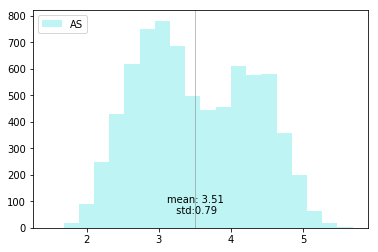

In [145]:
if phenotype_type=='binary':
    value=phenotype_define_df_noindex['pheno']
    phenotype_stat=pd.DataFrame([value[(phenotypes['cohort']==cohort).values].value_counts().rename(cohort_to_name(cohort)) for cohort in phenotypes['cohort'].unique()])
    phenotype_stat=phenotype_stat.rename(columns={2: 'case', 1: 'control',-9:'missing'})
    phenotype_stat=phenotype_stat[phenotype_stat.columns.sort_values()].fillna(0)
    phenotype_stat=phenotype_stat.loc[phenotype_stat.index.sort_values()]
    
    fig=plt.figure()
    plt.table(cellText=phenotype_stat.values,
              colWidths = [0.3]*3,
              rowLabels=phenotype_stat.index,
              colLabels=phenotype_stat.columns,
              loc='center right')
    plt.axis('off')
    #plt.show()    
    plt.savefig(pheno_file_path.format(phenotype_name)+'.svg')
    
    
if phenotype_type=='continuous':
    value=phenotype_define_df_noindex['pheno']
    
    fig=plt.figure()
    #plt.title(new_name)
    for cohort in sorted(phenotypes['cohort'].unique()):
        cohort_check=(phenotypes['cohort']==cohort).values
        #print(cohort_check)
        #print(value[cohort_check])
        if np.all(value[cohort_check]==-9):
            continue
        y, x, _ =plt.hist(value[cohort_check & (value!=-9)],bins=20,color=plt.cm.rainbow(cohort/3),label=cohort_to_name(cohort),alpha=0.3)
    plt.legend(loc='upper left')
    #plt.show()
    plt.axvline(x=value[value!=-9].mean(),linewidth=0.5,color='grey')
    plt.text(x=value[value!=-9].mean(),y=value[value!=-9].value_counts().max(),s='mean: {:.2f}\n std:{:.2f}'.format(value[(value!=-9)].mean(),value[(value!=-9)].std()) ,horizontalalignment='center',verticalalignment='center',)
    plt.savefig(pheno_file_path.format(phenotype_name)+'.svg')
    
    